In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.abspath(''))

In [2]:
from pytorch_lightning import Trainer
from datasets import load_dataset
from utils.dataset import EegRawDataset, EegSpecDataset, create_dataloaders

from models.cnn import CNNClassifier
from models.spenet import SpeNet
from pytorch_lightning.loggers import TensorBoardLogger

from utils.visualisation import plot_spectrogram
from utils.utils import LossLogger, GradientLogger

In [ ]:
# Choose MNIST EP or MNIST IN for the CNN Classifier
# Choose VisMNIST_Cap64 for the SpeNet

POSTFIXES = ["MNIST_EP", "MNIST_IN", "VisMNIST_Cap64"]

## Raw EEG

### Dataset

In [ ]:
train_dataset = load_dataset(f"DavidVivancos/MindBigData2022_{POSTFIXES[0]}", split="train")

In [4]:
full_eeg_dataset = EegRawDataset(train_dataset, low_cut=3, high_cut=63, classification_task="digit")

In [5]:
eeg_train_dataloader, eeg_val_dataloader = create_dataloaders(full_eeg_dataset, batch_size=128, train_split=0.9, seed=43, two_dimension=True)

### Training

In [ ]:
logger = TensorBoardLogger("tb_logs", name="cnn_classification")
loss_logger = LossLogger()
gradient_logger = GradientLogger()
cnn_classifier = CNNClassifier(
    input_channels=1,
    sequence_length=full_eeg_dataset.nb_samples,
    sequence_nb_channel=full_eeg_dataset.nb_channel,
    dropout_rate=0.1,
)
trainer = Trainer(
    max_epochs=500, logger=logger, callbacks=[gradient_logger, loss_logger]
)
trainer.fit(cnn_classifier, eeg_train_dataloader, eeg_val_dataloader)

## Spectrogram EEG

### Dataset

In [ ]:
train_dataset = load_dataset(f"DavidVivancos/MindBigData2022_{POSTFIXES[2]}", split="train")

In [ ]:
full_eeg_spectrogram_dataset = EegSpecDataset(train_dataset, sample_duration=2, low_cut=14, high_cut=73)

In [ ]:
eeg_spectogram_train_dataloader, eeg_spectogram_val_dataloader = create_dataloaders(
    full_eeg_spectrogram_dataset, batch_size=16, train_split=0.8, seed=45
)

### Plot a sample Spectrogram

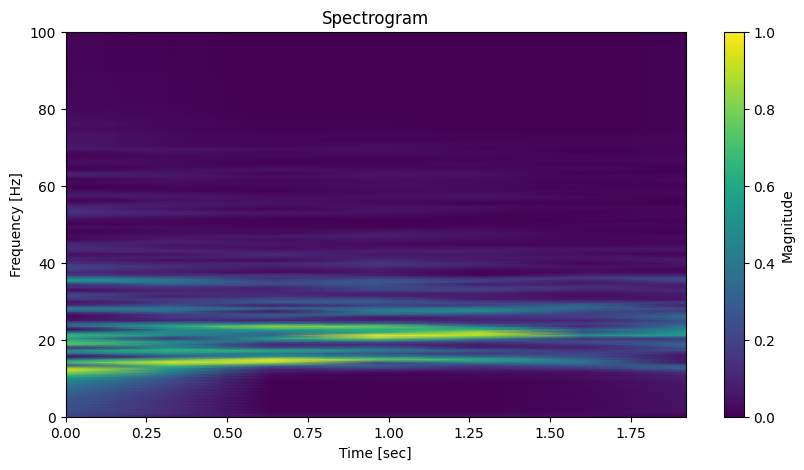

In [ ]:
channel = 0
sample = 0
spec = full_eeg_spectrogram_dataset[sample][0].reshape(64, -1,7)[channel]
plot_spectrogram(spec, fs=full_eeg_spectrogram_dataset.sampling_rate, hop_length=full_eeg_spectrogram_dataset.hop_length)

### Training

In [ ]:
logger = TensorBoardLogger("tb_logs", name="spe_net")
loss_logger = LossLogger()
gradient_logger = GradientLogger()
spenet = SpeNet(num_classes=2, dropout=0.2)
spenet.set_class_weights(full_eeg_spectrogram_dataset, alpha=1)
trainer = Trainer(
    max_epochs=500, callbacks=[loss_logger, gradient_logger], logger=logger
)
trainer.fit(spenet, eeg_spectogram_train_dataloader, eeg_spectogram_val_dataloader)